# ML Model Notebook

## Model Training

In [2]:
import sys

import numpy as np
import pandas as pd
import sklearn 
import datetime 
import PIL
import yellowbrick
import matplotlib

print(f"Python version \t\t {sys.version}")
print(f"NumPy version \t\t {pd.__version__}")
print(f"Pandas version \t\t {np.__version__}")
print(f"Scikit-learn version \t {sklearn.__version__}")

print(f"PIL version \t {PIL.__version__}")
print(f"Yellowbrick version \t {yellowbrick.__version__}")

print(f"Matplotlib version \t {matplotlib.__version__}")

today = datetime.datetime.now().date()-datetime.timedelta(days=1)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

Python version 		 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
NumPy version 		 1.3.4
Pandas version 		 1.19.5
Scikit-learn version 	 1.0.1
PIL version 	 8.4.0
Yellowbrick version 	 1.5
Matplotlib version 	 3.5.1


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

RANDOM_STATE = 23
TRAIN_TEST_SPLIT = 0.2

colors = ['CFP','Alexa488','Alexa568','Alexa647']
clustertype = 'cluster'
data_path = '../data/2022-11-23_uncorrected.csv'
ref_data_path = '../output/Tables/Proteome_to_ML_5PCbins.csv'
#ref_data_path = '../output/Tables/kmeans_5clusters.csv'

classifer = RandomForestClassifier(random_state = RANDOM_STATE, n_estimators=200)

data = pd.read_csv(data_path)
ref = pd.read_csv(ref_data_path)

replace_label_dict = {}
replace_label_dict[1] = 1
replace_label_dict[5] = 2
replace_label_dict[4] = 3
replace_label_dict[3] = 4
replace_label_dict[2] = 5

ref[clustertype] = ref[clustertype].replace(replace_label_dict)


X = []
y = []
indices = []

for i in range(len(ref)):

    row = ref.iloc[i]
    slide = row['Slide']
    idx = row['Index']
    cluster = row[clustertype]

    sub = data[(data['Index'] == idx) & (data['Slide'] == slide)].set_index('Channel').T
    X.append(sub[colors].iloc[2:-2].values.flatten()[:-len(colors)+1])

    y.append(cluster)
    indices.append(idx)


cols, idx = sub[colors].iloc[2:-2].index, sub[colors].iloc[2:-2].columns

col_names = []

for c in cols:
    for i in idx:
        col_names.append(i+'_'+c)

col_names = col_names[:-len(colors)] + ['Area']

X = np.array(X).astype('float')
X = pd.DataFrame(X, columns=col_names)

y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TRAIN_TEST_SPLIT, random_state = RANDOM_STATE)

c = clone(classifer)
c.fit(X_train, y_train)
y_pred_test = c.predict(X_test)
y_pred_train = c.predict(X_train)

test_acc = (y_pred_test == y_test).sum()/len(y_test)
train_acc = (y_pred_train == y_train).sum()/len(y_train)

print(test_acc, train_acc)

0.7538461538461538 1.0


## Export probability

For the test shapes, export the predicted class probabilities

In [10]:

probability_df = pd.DataFrame(c.predict_proba(X_test))
probability_df['Shape Index'] = np.array(indices)[X_test.index]
probability_df.to_csv(f"./export/{today}_shape_probability.csv") #Add m1A etc. 


FileNotFoundError: [Errno 2] No such file or directory: './export/2023-04-03_shape_probability.csv'

In [6]:
for slide in ['m1A','m4A','f1C']:
    data = pd.read_csv(f'./export/{today}_prediction_{slide}.csv')

    X_ = []
    indices = []

    for idx in data['Index'].unique():

        sub = data[(data['Index'] == idx) & (data['Slide'] == slide)].set_index('Channel').T
        X_.append(sub[colors].iloc[2:-2].values.flatten()[:-len(colors)+1])

        indices.append(idx)

    X_ = np.array(X_).astype('float')
    X_ = pd.DataFrame(X_)
    probability_df = pd.DataFrame(c.predict_proba(X_))
    probability_df['Shape Index'] = np.array(indices)[X_.index]
    probability_df.to_csv(f"./export/{today}_shape_probability_{slide}.csv")

/Users/flq567/miniconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/flq567/miniconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/flq567/miniconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [7]:
for slide in ['m1A_partial']:

    slide_ = 'm1A'
    data = pd.read_csv(f'./export/{today}_prediction_{slide}.csv')

    X_ = []
    indices = []

    for idx in data['Index'].unique():

        sub = data[(data['Index'] == idx) & (data['Slide'] == slide_)].set_index('Channel').T
        X_.append(sub[colors].iloc[2:-2].values.flatten()[:-len(colors)+1])

        indices.append(idx)


    X_ = np.array(X_).astype('float')
    X_ = pd.DataFrame(X_)
    probability_df = pd.DataFrame(c.predict_proba(X_))
    probability_df['Shape Index'] = np.array(indices)[X_.index]
    probability_df.to_csv(f"./export/{today}_shape_probability_{slide}.csv")

/Users/flq567/miniconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [8]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_test, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f"./export/{today}_classification_report.csv")

In [9]:
from yellowbrick.classifier import ConfusionMatrix, ClassPredictionError, ROCAUC, PrecisionRecallCurve, ClassificationReport
from yellowbrick.model_selection import FeatureImportances
import matplotlib.pyplot as plt

<AxesSubplot:title={'center':'Feature Importances of 17 Features using RandomForestClassifier'}, xlabel='relative importance'>

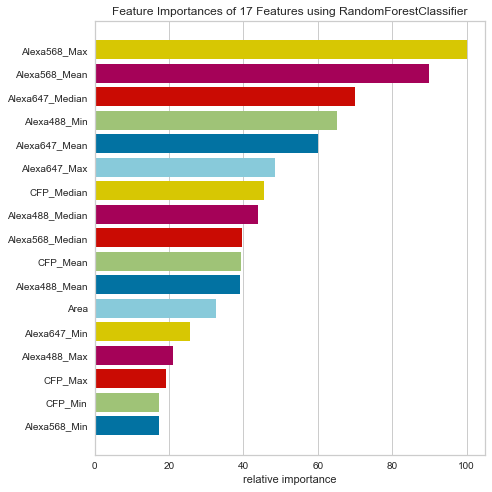

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
viz = FeatureImportances(clone(classifer), ax=ax)
viz.fit(X_train, y_train)
viz.show(outpath=f"./export/{today}_FeatureImportances.pdf")  

/Users/flq567/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

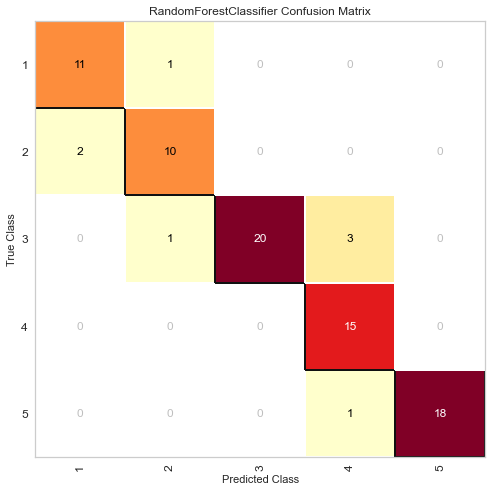

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))
viz = ConfusionMatrix(c, ax=ax)
viz.score(X_test, y_test)
viz.show(outpath=f"./export/{today}_ConfusionMatrix.pdf")  

## Class Prediction Error

/Users/flq567/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


<AxesSubplot:title={'center':'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

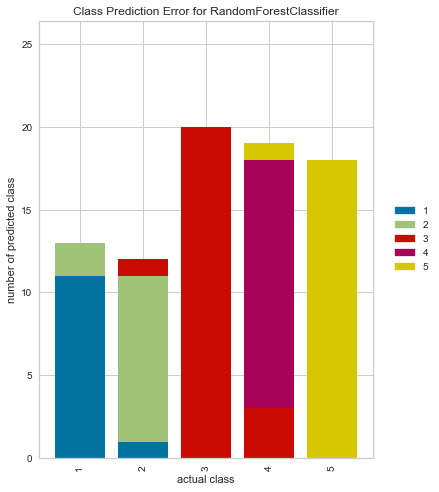

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
viz = ClassPredictionError(c, ax=ax)
viz.score(X_test, y_test)
viz.show(outpath=f"./export/{today}_ClassPredictionError.pdf")  

## ROCAUC

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

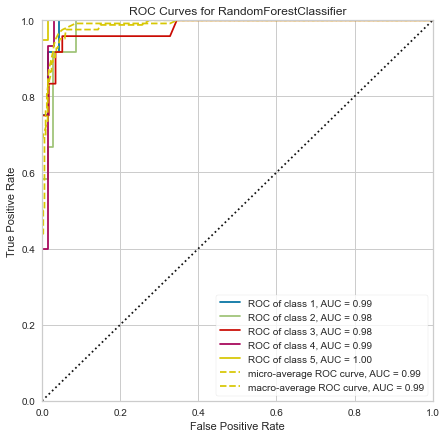

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))

model = clone(classifer)
viz = ROCAUC(model, ax=ax)
viz.fit(X_train, y_train)        
viz.score(X_test, y_test)
viz.show(outpath=f"./export/{today}_ROCAUC.pdf")  


## PrecisionRecallCurve

/Users/flq567/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

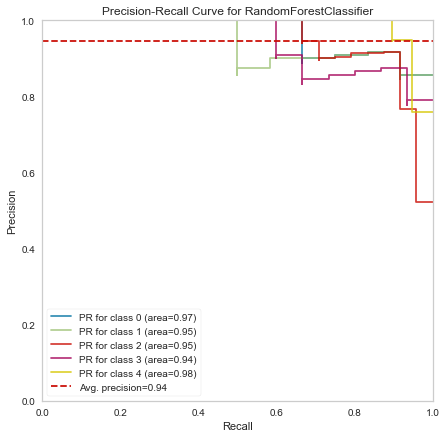

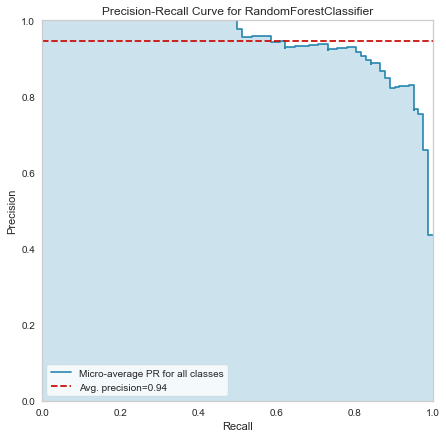

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))

model = clone(classifer)
viz = PrecisionRecallCurve(model, ax=ax, per_class=True)

viz.fit(X_train, y_train)        
viz.score(X_test, y_test)
viz.show(outpath=f"./export/{today}_PrecisionRecallCurve.pdf")  

fig, ax = plt.subplots(figsize=(7, 7))

model = clone(classifer)
viz = PrecisionRecallCurve(model, ax=ax, per_class=False)

viz.fit(X_train, y_train)        
viz.score(X_test, y_test)
viz.show(outpath=f"./export/{today}_PrecisionRecallCurve_all.pdf")  
